This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

# Chapter 2: Supervised Learning: Classification and Regression

# Linear online regression with River

* Linear online regression can be performed in `river` with the `LinearRegression` class 
from the `linear_model` module. 
* In the following example, the MAE (mean absolute error) error is measured during training.

## Laden der Daten

* First, we create a dataset for classification using the `sklearn.datasets` class `make_classification`.

In [1]:
## Generate a classification dataset with sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, n_features=20, n_informative=2, n_redundant=2, random_state=42)

## Convert X to a pandas dataframe
import pandas as pd
X = pd.DataFrame(X)
y = pd.Series(y)


## Metric Selection and Data Preprocessing

* The Mean Absolute Error (MAE) is selected as the metric.
* In addition, the scaling of the data is specified:
  * By selecting the `StandardScalers` class, the data is scaled to have zero mean and one variance.
  * Internally, a running mean and running variance are determined. This scaling differs slightly from the scaling of the data in the batch because the exact means and variances are not known in advance.

In [2]:
from river import metrics
from river import preprocessing

metric = metrics.MAE()
scaler = preprocessing.StandardScaler()

## Selection of the model

* In the next step the model (here the `LinearRegression`) is selected.
* For the sequential online optimization of the model coefficients, the stochastic gradient descent (`SGD`) is selected.
  * The learning rate for `SGD` is set to 0.01. 
  * The setting of a suitable learning rate is crucial for the optimization.

In [3]:
from river import optim
from river import linear_model

optimizer = optim.SGD(lr=0.01)
lin_reg = linear_model.LinearRegression(optimizer)

# Pipelines

* The following example is based on [https://riverml.xyz/latest/recipes/pipelines/](https://riverml.xyz/latest/recipes/pipelines/).
* The compose.Pipeline contains all the logic for building and applying pipelines.
* A pipeline is essentially a list of estimators that are applied in sequence.
* The only requirement is that the first n - 1 steps be transformers.
* The last step can be a regressor, a classifier, a clusterer, a transformer, etc. Here is an example:

In [4]:
from river import compose
from river import linear_model
from river import preprocessing
from river import feature_extraction

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

* The model can be visualized:

In [5]:
print(model)

StandardScaler | LinearRegression


In [6]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

* `compose.Pipeline` inherits from `base.Estimator` and thus has a `learn_one` method.
* Before river v.0.19.0, the `learn_one` method updated the supervised parts of the pipeline.
* This behavior change in river v.0.19.0, where the `learn_one` method now updates the entire pipeline.
* The `predict_one` method updated the unsupervised parts of the pipeline (and not the supervised parts?).
* Let's see how this works in the following example.

In [7]:
from river import datasets

dataset = datasets.TrumpApproval()
x, y = next(iter(dataset))
x, y

({'ordinal_date': 736389,
  'gallup': 43.843213,
  'ipsos': 46.19925042857143,
  'morning_consult': 48.318749,
  'rasmussen': 44.104692,
  'you_gov': 43.636914000000004},
 43.75505)

* Take a look at the unsupervised parts of the pipeline, i.e. the `StandardScaler`:

In [8]:
model['StandardScaler'].means

defaultdict(float, {})

* The unsupervised parts of the pipeline empty, because no data has been passed through the pipeline yet.
* If we call the `predict_one` method, only the unsupervised parts of the pipeline are updated, but not the model (supervised parts).

In [9]:
model.predict_one(x)

0.0

In [10]:
model['StandardScaler'].means

defaultdict(float,
            {'ordinal_date': 0.0,
             'gallup': 0.0,
             'ipsos': 0.0,
             'morning_consult': 0.0,
             'rasmussen': 0.0,
             'you_gov': 0.0})

* As we can see, the means of each feature have been updated (they were standardized and have a zero mean), even though we called `predict_one` and not `learn_one`.
* Now let's take a look at the supervised parts of the pipeline, i.e., the model and its weights:

In [11]:
model["LinearRegression"].weights

{}

* Since we have called `predict_one` and not `learn_one`, the model has not been updated.
* The model weights are empty, as expected.

* We can even call `transform_one` with this model (that does not have any weights) and it will work, because the output from the last transformer (which is thus the penultimate step) will be returned in this case:

In [12]:
model.transform_one(x)

{'ordinal_date': 0.0,
 'gallup': 0.0,
 'ipsos': 0.0,
 'morning_consult': 0.0,
 'rasmussen': 0.0,
 'you_gov': 0.0}

* Calling `transform_one` does not update the model weights, as expected:

In [13]:
model["LinearRegression"].weights

{}

* However, usually we want to update the model weights, so we should call `learn_one`:

In [14]:
model.learn_one(x, y)
model["LinearRegression"].weights

{'ordinal_date': 0.0,
 'gallup': 0.0,
 'ipsos': 0.0,
 'morning_consult': 0.0,
 'rasmussen': 0.0,
 'you_gov': 0.0}

* Finally, after calling `learn_one`, the model weights have been updated.

In [15]:
from river import datasets

dataset = datasets.Bananas()
x, y = next(iter(dataset))
x, y

({'1': 1.617466, '2': -0.919233}, False)

In [16]:
from river import linear_model
from river import optim
from river import preprocessing
from river import stream
from river import metrics
from sklearn.metrics import roc_auc_score

scaler = preprocessing.StandardScaler()
optimizer = optim.SGD(lr=0.01)
log_reg = linear_model.LogisticRegression(optimizer)

y_true = []
y_pred = []

for xi, yi in dataset:

    # Scale the features
    scaler.learn_one(xi)
    xi_scaled = scaler.transform_one(xi)

    # Test the current model on the new "unobserved" sample
    yi_pred = log_reg.predict_proba_one(xi_scaled)
    # Train the model with the new sample
    log_reg.learn_one(xi_scaled, yi)

    # Store the truth and the prediction
    y_true.append(yi)
    y_pred.append(yi_pred[True])

print(f"y: {y_true[:5]}")
print(f"y_pred: {y_pred[:5]}")
# print(f'ROC AUC: {metrics.Accuracy(y_true, y_pred):.3f}')
print(f'ROC AUC: {roc_auc_score(y_true, y_pred):.3f}')

y: [False, False, False, True, False]
y_pred: [0.5, 0.49875000260416025, 0.49630192029693704, 0.4972573428558144, 0.49592426466972106]
ROC AUC: 0.544


# Metric and metric.update()

In [17]:
from river import metrics
from river import datasets
from river import linear_model

dataset = datasets.Phishing()
model = linear_model.LogisticRegression()
metric = metrics.ROCAUC()
for x, y in dataset:
    y_pred = model.predict_proba_one(x)
    model.learn_one(x, y)
    print(f"y: {y}, y_pred: {y_pred}")
    metric.update(y, y_pred)

y: True, y_pred: {False: 0.5, True: 0.5}
y: True, y_pred: {False: 0.4971875296627105, True: 0.5028124703372895}
y: True, y_pred: {False: 0.49376965822249996, True: 0.5062303417775}
y: True, y_pred: {False: 0.49192870317923, True: 0.50807129682077}
y: False, y_pred: {False: 0.4854329829035461, True: 0.5145670170964539}
y: False, y_pred: {False: 0.488761369128878, True: 0.511238630871122}
y: True, y_pred: {False: 0.4958461672260852, True: 0.5041538327739148}
y: True, y_pred: {False: 0.49273510619655947, True: 0.5072648938034405}
y: False, y_pred: {False: 0.49304702630217423, True: 0.5069529736978258}
y: True, y_pred: {False: 0.4968133893502038, True: 0.5031866106497962}
y: False, y_pred: {False: 0.4918142273117062, True: 0.5081857726882938}
y: True, y_pred: {False: 0.49732316630931683, True: 0.5026768336906832}
y: True, y_pred: {False: 0.49307780403643875, True: 0.5069221959635613}
y: True, y_pred: {False: 0.4898665759083809, True: 0.5101334240916191}
y: False, y_pred: {False: 0.48835355

## Test-then-train 

* Now the single samples of the dataset are used for testing and training. 
  * For each sample, the metric is updated.
* Finally, the metric that was incrementally calculated on the data from the entire process is available.

In [18]:
## Generate a classification dataset with sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1_000, n_features=3, n_informative=2, n_redundant=1, random_state=42)

## Convert X to a pandas dataframe
import pandas as pd
X = pd.DataFrame(X)
# convert y to boolean
y = pd.Series(y).astype(bool)
y = pd.Series(y)
print(X.head())
print(y.head())

          0         1         2
0  2.485478  2.399636 -1.465269
1  2.204040 -1.069657  0.009795
2 -0.572653 -0.754948  0.420330
3 -0.990616  3.909762 -1.408300
4 -1.287894  1.896194 -0.526160
0     True
1    False
2    False
3     True
4     True
dtype: bool


## Aug, 14th 2024 Note:

* The following code does not work under `river 0.21.2`.
* It results in the following error (probably caused by an typo in the `river` code):

File ~/.conda/envs/spot/lib/python3.11/site-packages/river/metrics/roc_auc.py:103, in ROCAUC.get(self)
    100     tprs[i] = safe_div(a=tp, b=tp + fn)
    101     fprs[i] = safe_div(a=fp, b=fp + tn)
--> 103 return -integrate.trapz(x=fprs, y=tprs)

AttributeError: module 'scipy.integrate' has no attribute 'trapz'

You can fix this error by replacing the line `return -integrate.trapz(x=fprs, y=tprs)` with `return -integrate.trapezoid(x=fprs, y=tprs)` in the file `site-packages/river/metrics/roc_auc.py` (you have to locate the folder `site-packages` in your Python environment).

In [19]:
from river import stream
from river import linear_model
from river import preprocessing
from river import metrics
from scipy import integrate

# scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()
log_reg = linear_model.LogisticRegression()
metric = metrics.ROCAUC()

y_true = []
y_pred = []
metric_list = []

for xi, yi in stream.iter_pandas(X, y):

    print(f"xi: {xi}")

    # Before river 0.21.0:
    # Scale the features
    #xi_scaled = scaler.learn_one(xi).transform_one(xi)

    # After 0.21.0:
    scaler.learn_one(xi)
    xi_scaled = scaler.transform_one(xi)

    print(f"xi_scaled: {xi_scaled}")

    # Test the current model on the new "unobserved" sample
    yi_pred = log_reg.predict_proba_one(xi_scaled)
    # yi_pred = log_reg.predict_one(xi_scaled)
    print(f"yi: {yi}, yi_pred: {yi_pred}")

    # Train the model with the new sample
    log_reg.learn_one(xi_scaled, yi)

    metric.update(yi, yi_pred)
    print(f"metric: {metric}")
    # Store the metric after each sample in a list
    metric_list.append(metric.get())

    # Store the truth and the prediction
    y_true.append(yi)
    y_pred.append(yi_pred)
    print(f"y: {y_true[:5]}")
    print(f"y_pred: {y_pred[:5]}")


print(f"Final metric: {metric}")

xi: {0: 2.485477863898728, 1: 2.399635889224372, 2: -1.4652691667153481}
xi_scaled: {0: 0.0, 1: 0.0, 2: 0.0}
yi: True, yi_pred: {False: 0.5, True: 0.5}
metric: ROCAUC: -0.00%
y: [True]
y_pred: [{False: 0.5, True: 0.5}]
xi: {0: 2.2040396196799588, 1: -1.0696565175358983, 2: 0.009795448072091794}
xi_scaled: {0: 0.0, 1: 0.0, 2: 1.0}
yi: False, yi_pred: {False: 0.49875000260416014, True: 0.5012499973958399}
metric: ROCAUC: 50.00%
y: [True, False]
y_pred: [{False: 0.5, True: 0.5}, {False: 0.49875000260416014, True: 0.5012499973958399}]
xi: {0: -0.5726534002171271, 1: -0.7549478806236055, 2: 0.42032990522871766}
xi_scaled: {0: 0.0, 1: 0.09071262955496369, 2: 1.0}
yi: False, yi_pred: {False: 0.5012562473435611, True: 0.4987437526564389}
metric: ROCAUC: 50.00%
y: [True, False, False]
y_pred: [{False: 0.5, True: 0.5}, {False: 0.49875000260416014, True: 0.5012499973958399}, {False: 0.5012562473435611, True: 0.4987437526564389}]
xi: {0: -0.9906155433694105, 1: 3.909761909687836, 2: -1.40830038604

## Plotting the values of the metric_list versus the sample number.

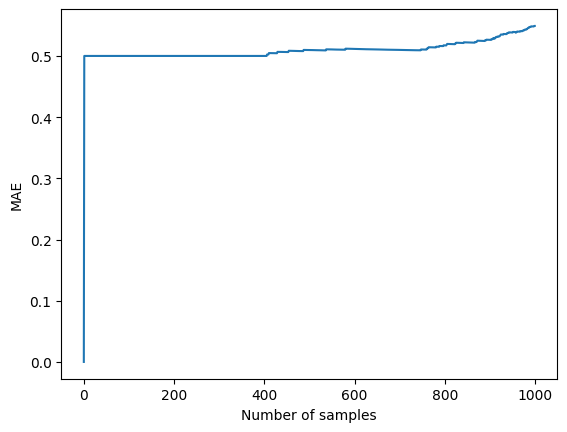

In [20]:
import matplotlib.pyplot as plt
# Plot the values of the metric_list verus the number of samples
plt.plot(metric_list)
plt.xlabel("Number of samples")
plt.ylabel("MAE")
plt.show()

* Da der `SGD` nicht-deterministisch ist, führt jeder Aufruf zu einem (leicht) modifizierten Ergebnis.

# SVM (ALMA) Classification for Synthetic Data

## Loading the data 

* Synthetic classification data is generated using the `make_classification` function from the `sklearn` package, see [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).
  * This function allows the creation of classification problems with $n$ classes.
  * In our example, $n=2$ is chosen (this is the default).  
* The data is then split into the training and test datasets using the `train_test_split` function.

In [21]:
from sklearn.datasets import make_classification
from river import linear_model

X, y = make_classification(shuffle=True, n_samples=2000)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## Model Selection and Model Fit

In [22]:
model = linear_model.ALMAClassifier()

# fit the model
for x_i,y_i in zip(X_train,y_train):
    x_json = {'val'+str(i): x for i,x in enumerate(x_i)}
    model.learn_one(x_json,y_i)


## Predict on the test set and compute the accuracy

In [23]:
preds = []
for x_i in X_test:
    x_json = {'val'+str(i): x for i,x in enumerate(x_i)}
    preds.append(model.predict_one(x_json))

# compute accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

0.8287878787878787

## Show the scikit-learn "classification report"

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       322
           1       0.82      0.86      0.84       338

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660



# SVM (ALMA) classification for a sklearn classification dataset

In [25]:
## Generate a classification dataset with sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, n_features=20, n_informative=2, n_redundant=2, random_state=42)

scaler = preprocessing.StandardScaler()


## Convert X to a pandas dataframe
import pandas as pd
X = pd.DataFrame(X)
y = pd.Series(y)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

* The model is fitted on the training data:

In [27]:
model = linear_model.ALMAClassifier()
for xi, yi in stream.iter_pandas(X_train,y_train):

    # Before river 0.21.0:
    # Scale the features
    # xi_scaled = scaler.learn_one(xi).transform_one(xi)

    # After 0.21.0:
    scaler.learn_one(xi)
    xi_scaled = scaler.transform_one(xi)

    model.learn_one(xi_scaled, yi) 

*  Prediction on the test data:

In [28]:
preds = []
for xi, _ in stream.iter_pandas(X_test):    

    # Before river 0.21.0:
    # Scale the features
    # xi_scaled = scaler.learn_one(xi).transform_one(xi)

    # After 0.21.0:
    scaler.learn_one(xi)
    xi_scaled = scaler.transform_one(xi)

    preds.append(model.predict_one(xi_scaled))

* Computation of the accuracy metric:

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

0.8412121212121212

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1657
           1       0.83      0.85      0.84      1643

    accuracy                           0.84      3300
   macro avg       0.84      0.84      0.84      3300
weighted avg       0.84      0.84      0.84      3300



# Passiv-Aggressiv Classification for Synthetic Data

In [31]:
from sklearn.datasets import make_classification
X,y=make_classification(shuffle=True,n_samples=2000)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from river import linear_model

model = linear_model.PAClassifier()

for x_i,y_i in zip(X_train,y_train):
    x_json = {'val'+str(i): x for i,x in enumerate(x_i)}
    model.learn_one(x_json,y_i)
    

preds = []
for x_i in X_test:
    x_json = {'val'+str(i): x for i,x in enumerate(x_i)}
    preds.append(model.predict_one(x_json))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

0.9

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       334
           1       0.92      0.88      0.90       326

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660



# Classification Tree

{0: 6.394267984578837, 1: 0.25010755222666936, 2: 2.7502931836911926} False
{'x_0': 6.394267984578837, 'x_1': 0.25010755222666936, 'x_2': 2.7502931836911926} False
{0: 2.2321073814882277, 1: 7.364712141640124, 2: 6.766994874229113} True
{'x_0': 2.2321073814882277, 'x_1': 7.364712141640124, 'x_2': 6.766994874229113} True
{0: 8.921795677048454, 1: 0.8693883262941615, 2: 4.2192181968527045} True
{'x_0': 8.921795677048454, 'x_1': 0.8693883262941615, 'x_2': 4.2192181968527045} True
{0: 0.29797219438070344, 1: 2.1863797480360336, 2: 5.053552881033624} False
{'x_0': 0.29797219438070344, 'x_1': 2.1863797480360336, 'x_2': 5.053552881033624} False
{0: 0.26535969683863625, 1: 1.988376506866485, 2: 6.498844377795232} False
{'x_0': 0.26535969683863625, 'x_1': 1.988376506866485, 'x_2': 6.498844377795232} False
{0: 5.449414806032166, 1: 2.204406220406967, 2: 5.892656838759088} False
{'x_0': 5.449414806032166, 'x_1': 2.204406220406967, 'x_2': 5.892656838759088} False
{0: 8.094304566778266, 1: 0.064987

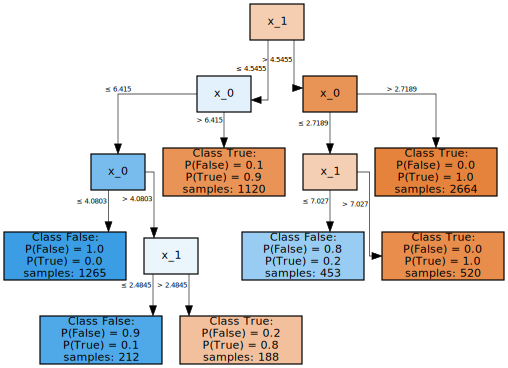

In [33]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing
from river.datasets import synth
from river import tree

from river.datasets import synth

dataset = synth.SEA(variant=0, seed=42)
#dataset = datasets.Phishing()
data = dataset.take(10000)

model = tree.HoeffdingTreeClassifier(grace_period=50)

for x, y in data:
    print(x, y)
    x = {f'x_{key}': value for key, value in x.items()}
    print(x,y)
    model.learn_one(x, y)

model

model.summary

model.draw()
